# Convolutional Neural Networks

# ================================
# SECTION 1: SETUP AND IMPORTS
# ================================

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import pickle
import os
import requests
from io import StringIO

warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Chemistry
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdDistGeom
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule



## ================================
# SECTION 2: DATASET LOADING (Using ESOL)
# ================================

Loaded ESOL with 1128 compounds
Columns in dataset: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']
Dataset shape: (1128, 2)
LogS range: -11.60 to 1.58

Sample data:
                                              SMILES  LogS
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.77
1                             Cc1occc1C(=O)Nc2ccccc2 -3.30
2                               CC(C)=CCCC(C)=CC(=O) -2.06
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.87
4                                            c1ccsc1 -1.33


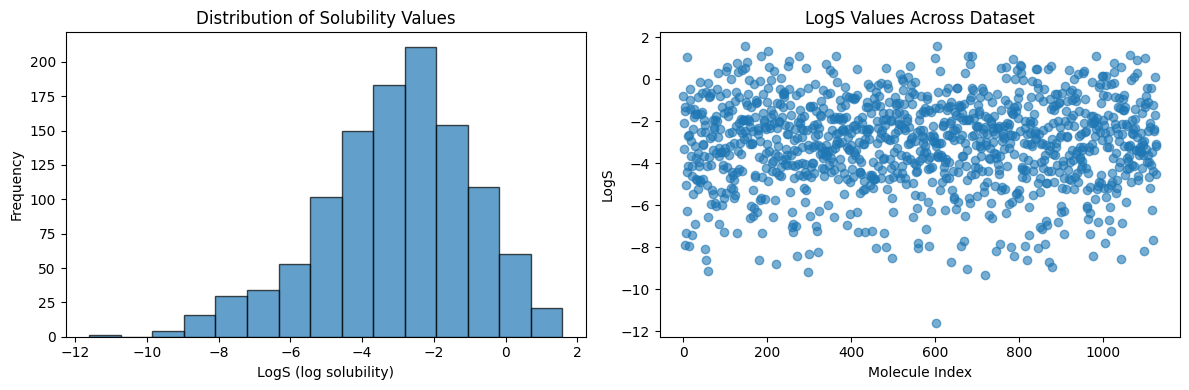

In [2]:

def load_esol_dataset():
    """Load the ESOL (Delaney) solubility dataset"""
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)
    response.raise_for_status()

    df = pd.read_csv(StringIO(response.text))
    print(f"Loaded ESOL with {len(df)} compounds")
    print("Columns in dataset:", df.columns.tolist())
    # Use 'smiles' and 'measured log solubility in mols per litre'
    df = df[['smiles', 'measured log solubility in mols per litre']]
    df.columns = ['SMILES', 'LogS']

    # Remove invalid SMILES
    valid_smiles = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        valid_smiles.append(mol is not None)

    df = df[valid_smiles].reset_index(drop=True)

    return df

# Load dataset
df = load_esol_dataset()
print(f"Dataset shape: {df.shape}")
print(f"LogS range: {df['LogS'].min():.2f} to {df['LogS'].max():.2f}")
print("\nSample data:")
print(df.head())

# Visualize distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogS (log solubility)')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility Values')

plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogS')
plt.title('LogS Values Across Dataset')
plt.tight_layout()
plt.show()

In [3]:
all_atoms = dict()
def extract_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return set()
    return {atom.GetSymbol() for atom in mol.GetAtoms()},len(mol.GetAtoms())
max_atoms = 0
for smiles in tqdm(df['SMILES'], desc="Extracting atoms"):
    atoms, size = extract_atoms(smiles)
    if size > max_atoms:
        max_atoms = size
    for atom in set(atoms):
        if atom not in all_atoms:
            all_atoms[atom] = 0
        all_atoms[atom] += 1
print(f"Unique atoms in dataset: {len(all_atoms)}")
for atom in all_atoms:
    print(f"{atom}: {all_atoms[atom]} occurrences")
print(f"Maximum number of atoms in a molecule: {max_atoms}")



Extracting atoms: 100%|██████████| 1128/1128 [00:00<00:00, 6876.55it/s]

Unique atoms in dataset: 9
N: 457 occurrences
O: 725 occurrences
C: 1128 occurrences
S: 116 occurrences
Cl: 252 occurrences
P: 43 occurrences
F: 44 occurrences
I: 16 occurrences
Br: 50 occurrences
Maximum number of atoms in a molecule: 55


As there as other atom types in a lot of atoms, we could try increasing the no of channels in input.


# ================================
# SECTION 3: 3D MOLECULAR REPRESENTATION
# ================================

Generating 3D conformation for: OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
Voxel grid shape: (4, 16, 16, 16)
Non-zero voxels: 58


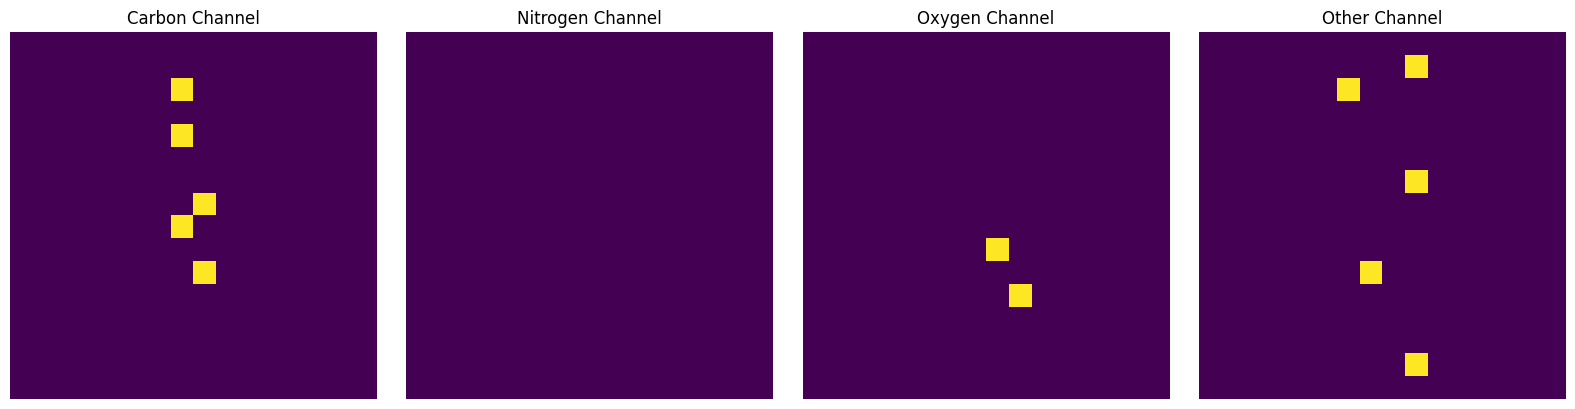

In [4]:

def generate_3d_conformation(smiles, max_attempts=10):
    """Generate 3D conformation from SMILES"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Add hydrogens
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates
    for attempt in range(max_attempts):
        try:
            # Embed molecule in 3D
            result = rdDistGeom.EmbedMolecule(mol, randomSeed=42+attempt)
            if result == -1:
                continue

            # Optimize geometry with UFF
            UFFOptimizeMolecule(mol)
            return mol

        except Exception as e:
            continue

    return None

def molecule_to_voxel_grid(mol, grid_size=16, voxel_size=1.0):
    """
    Convert 3D molecule to voxel grid representation

    Args:
        mol: RDKit molecule with 3D coordinates
        grid_size: Size of cubic voxel grid
        voxel_size: Size of each voxel in Angstroms

    Returns:
        4D numpy array (channels, x, y, z) where channels represent atom types
    """
    if mol is None:
        return np.zeros((4, grid_size, grid_size, grid_size))

    # Define atom type mapping
    atom_types = {'C': 0, 'N': 1, 'O': 2, 'Other': 3}

    # Initialize voxel grid (4 channels for different atom types)
    voxel_grid = np.zeros((4, grid_size, grid_size, grid_size))

    # Get atomic coordinates
    conformer = mol.GetConformer()

    # Calculate molecule center
    coords = []
    for atom_idx in range(mol.GetNumAtoms()):
        pos = conformer.GetAtomPosition(atom_idx)
        coords.append([pos.x, pos.y, pos.z])

    coords = np.array(coords)
    center = np.mean(coords, axis=0)

    # Place atoms in voxel grid
    for atom_idx in range(mol.GetNumAtoms()):
        atom = mol.GetAtomWithIdx(atom_idx)
        pos = conformer.GetAtomPosition(atom_idx)

        # Center coordinates
        x = pos.x - center[0]
        y = pos.y - center[1]
        z = pos.z - center[2]

        # Convert to voxel indices
        voxel_x = int((x / voxel_size) + grid_size // 2)
        voxel_y = int((y / voxel_size) + grid_size // 2)
        voxel_z = int((z / voxel_size) + grid_size // 2)

        # Check bounds
        if (0 <= voxel_x < grid_size and
            0 <= voxel_y < grid_size and
            0 <= voxel_z < grid_size):

            # Get atom type channel
            atom_symbol = atom.GetSymbol()
            channel = atom_types.get(atom_symbol, atom_types['Other'])

            # Set voxel value (can use atomic number, van der Waals radius, etc.)
            voxel_grid[channel, voxel_x, voxel_y, voxel_z] = 1.0

    return voxel_grid

# Example: Generate 3D representation
example_smiles = df.iloc[0]['SMILES']  # First molecule in dataset
print(f"Generating 3D conformation for: {example_smiles}")

mol_3d = generate_3d_conformation(example_smiles)
if mol_3d is not None:
    voxel_grid = molecule_to_voxel_grid(mol_3d, grid_size=16)
    print(f"Voxel grid shape: {voxel_grid.shape}")
    print(f"Non-zero voxels: {np.sum(voxel_grid > 0)}")

    # Visualize different atom type channels
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    channel_names = ['Carbon', 'Nitrogen', 'Oxygen', 'Other']

    for i, (channel, name) in enumerate(zip(voxel_grid, channel_names)):
        # Show middle slice of voxel grid
        slice_2d = channel[:, :, channel.shape[2]//2]
        axes[i].imshow(slice_2d, cmap='viridis')
        axes[i].set_title(f'{name} Channel')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# ================================
# SECTION 4: 3D MOLECULAR DATASET
# ================================

In [5]:

class Molecular3DDataset(Dataset):
    """Dataset for 3D molecular voxel grids"""

    def __init__(self, smiles_list, labels, grid_size=16, voxel_size=1.0,
                 augment=False, cache_path=None):
        self.smiles_list = smiles_list
        self.labels = labels
        self.grid_size = grid_size
        self.voxel_size = voxel_size
        self.augment = augment
        self.cache_path = cache_path

        # Pre-compute voxel grids
        self.voxel_grids = []
        self.valid_indices = []

        # Try to load from cache
        if cache_path and os.path.exists(cache_path):
            print("Loading cached voxel grids...")
            with open(cache_path, 'rb') as f:
                cached_data = pickle.load(f)
                self.voxel_grids = cached_data['voxel_grids']
                self.valid_indices = cached_data['valid_indices']
        else:
            print("Generating 3D molecular conformations...")
            self._generate_voxel_grids()

            # Save to cache
            if cache_path:
                with open(cache_path, 'wb') as f:
                    pickle.dump({
                        'voxel_grids': self.voxel_grids,
                        'valid_indices': self.valid_indices
                    }, f)

        print(f"Valid 3D molecules: {len(self.valid_indices)}/{len(smiles_list)}")

    def _generate_voxel_grids(self):
        """Generate voxel grids for all molecules"""
        for i, smiles in enumerate(tqdm(self.smiles_list, desc="Processing molecules")):
            mol_3d = generate_3d_conformation(smiles)

            if mol_3d is not None:
                voxel_grid = molecule_to_voxel_grid(mol_3d, self.grid_size, self.voxel_size)

                # Only keep molecules with atoms in the grid
                if np.sum(voxel_grid) > 0:
                    self.voxel_grids.append(voxel_grid)
                    self.valid_indices.append(i)


    def _augment_voxel_grid(self, voxel_grid):
        """Apply random rotations and flips to voxel grid"""
        if not self.augment:
            return voxel_grid

        # Random rotation around axes
        for axis in [1, 2, 3]:  # Skip channel axis
            if np.random.random() > 0.5:
                k = np.random.randint(1, 4)
                voxel_grid = np.rot90(voxel_grid, k=k, axes=(axis, (axis % 3) + 1))

        # Random flipping
        for axis in [1, 2, 3]:
            if np.random.random() > 0.5:
                voxel_grid = np.flip(voxel_grid, axis=axis)
        # Add noise (optional)
        # voxel_grid += np.random.normal(0, 0.1, voxel_grid.shape)

        return voxel_grid.copy()

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        voxel_grid = self.voxel_grids[idx]
        actual_idx = self.valid_indices[idx]
        label = self.labels[actual_idx]

        # Apply augmentation
        voxel_grid = self._augment_voxel_grid(voxel_grid)

        return torch.FloatTensor(voxel_grid), torch.FloatTensor([label])



In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['SMILES'].values, df['LogS'].values,
    test_size=0.2, random_state=42
)

# Create datasets with caching for faster reload
train_dataset = Molecular3DDataset(
    X_train, y_train, grid_size=16, augment=True,
    cache_path=None
)
test_dataset = Molecular3DDataset(
    X_test, y_test, grid_size=16, augment=False,
    cache_path=None
)

# Create data loaders
batch_size = 8  # Smaller batch for 3D data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Generating 3D molecular conformations...


Processing molecules: 100%|██████████| 902/902 [00:16<00:00, 55.53it/s]


Valid 3D molecules: 902/902
Generating 3D molecular conformations...


Processing molecules: 100%|██████████| 226/226 [00:03<00:00, 59.75it/s]

Valid 3D molecules: 226/226
Training samples: 902
Test samples: 226



# ================================
# SECTION 5: 3D CNN ARCHITECTURE
# ================================

In [7]:

class Molecular3DCNN(nn.Module):
    """3D CNN for molecular property prediction"""

    def __init__(self, input_channels=4, num_classes=1, dropout_rate=0.3):
        super(Molecular3DCNN, self).__init__()

        # 3D Convolutional layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((2, 2, 2)),  # Adaptive pooling for consistent output size
        )

        # Regression head
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 2 * 2 * 2, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Molecular3DCNN(num_classes=1).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 559,521
Trainable parameters: 559,521



# ================================
# SECTION 6: TRAINING FUNCTION
# ================================

Training 3D CNN...
Epoch [1/50], Train Loss: 3.7914, Test Loss: 2.4140, Test R²: 0.4826
Epoch [2/50], Train Loss: 2.6411, Test Loss: 1.8243, Test R²: 0.6042
Epoch [3/50], Train Loss: 2.8793, Test Loss: 1.5070, Test R²: 0.6728
Epoch [4/50], Train Loss: 2.6438, Test Loss: 1.7434, Test R²: 0.6229
Epoch [5/50], Train Loss: 2.6668, Test Loss: 1.6920, Test R²: 0.6328
Epoch [6/50], Train Loss: 2.1978, Test Loss: 1.3787, Test R²: 0.7011
Epoch [7/50], Train Loss: 2.8487, Test Loss: 1.5889, Test R²: 0.6549
Epoch [8/50], Train Loss: 2.4831, Test Loss: 1.3666, Test R²: 0.7063
Epoch [9/50], Train Loss: 2.2798, Test Loss: 1.5043, Test R²: 0.6751
Epoch [10/50], Train Loss: 2.2288, Test Loss: 1.9062, Test R²: 0.5921
Epoch [11/50], Train Loss: 2.2193, Test Loss: 1.3445, Test R²: 0.7092
Epoch [12/50], Train Loss: 2.4453, Test Loss: 1.7398, Test R²: 0.6226
Epoch [13/50], Train Loss: 2.1221, Test Loss: 1.2662, Test R²: 0.7261
Epoch [14/50], Train Loss: 2.1184, Test Loss: 1.6941, Test R²: 0.6322
Epoch [15/

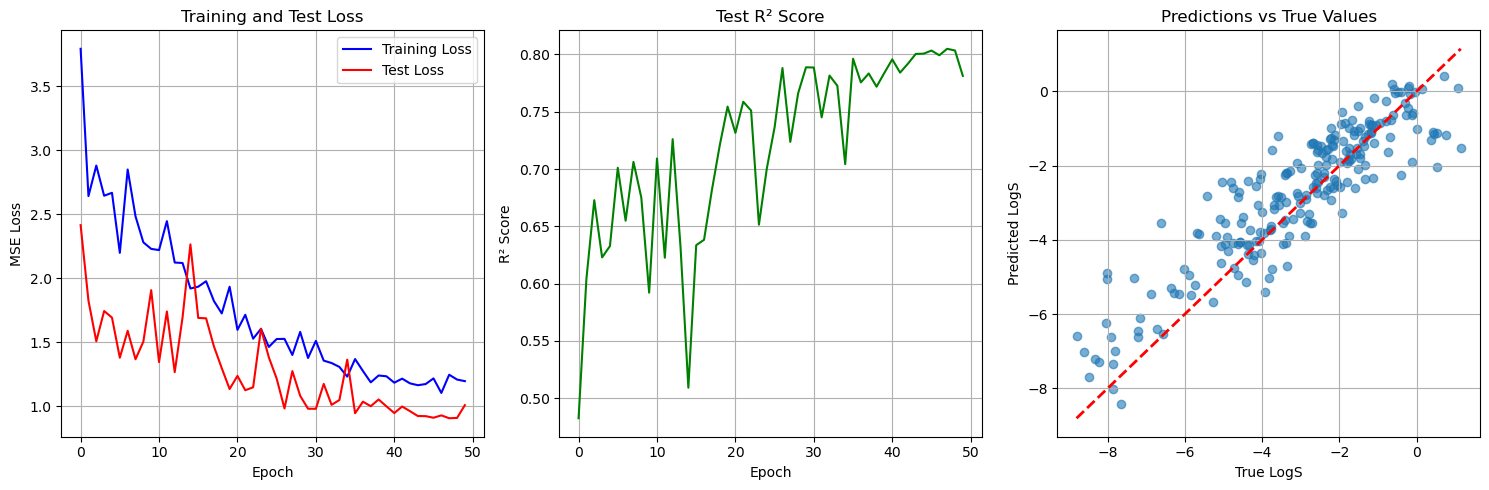

In [8]:

def train_3d_model(model, train_loader, test_loader, num_epochs=15, learning_rate=0.001):
    """Train the 3D CNN model"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    train_losses = []
    test_losses = []
    test_r2_scores = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0

        for voxel_grids, labels in train_loader:
            voxel_grids, labels = voxel_grids.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(voxel_grids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)

        # Evaluation
        model.eval()
        test_loss = 0.0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for voxel_grids, labels in test_loader:
                voxel_grids, labels = voxel_grids.to(device), labels.to(device)
                outputs = model(voxel_grids)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                all_predictions.extend(outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = test_loss / len(test_loader)

        # Calculate R² score
        r2 = r2_score(all_labels, all_predictions)

        scheduler.step(test_loss)

        # Store metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_r2_scores.append(r2)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, '
              f'Test R²: {r2:.4f}')

    return train_losses, test_losses, test_r2_scores

# Train the model
print("Training 3D CNN...")
train_losses, test_losses, test_r2 = train_3d_model(
    model, train_loader, test_loader, num_epochs=50, learning_rate=0.001
)

# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(test_r2, label='Test R²', color='green')
plt.title('Test R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.grid(True)

plt.subplot(1, 3, 3)
# Final predictions vs actual
model.eval()
final_predictions = []
final_labels = []

with torch.no_grad():
    for voxel_grids, labels in test_loader:
        voxel_grids, labels = voxel_grids.to(device), labels.to(device)
        outputs = model(voxel_grids)
        final_predictions.extend(outputs.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())

plt.scatter(final_labels, final_predictions, alpha=0.6)
plt.plot([min(final_labels), max(final_labels)],
         [min(final_labels), max(final_labels)], 'r--', lw=2)
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('Predictions vs True Values')
plt.grid(True)

plt.tight_layout()
plt.show()


# ================================
# SECTION 7: MODEL EVALUATION
# ================================

=== 3D CNN Model Evaluation ===
R² Score: 0.7813
RMSE: 1.0168
MAE: 0.7722
MSE: 1.0338


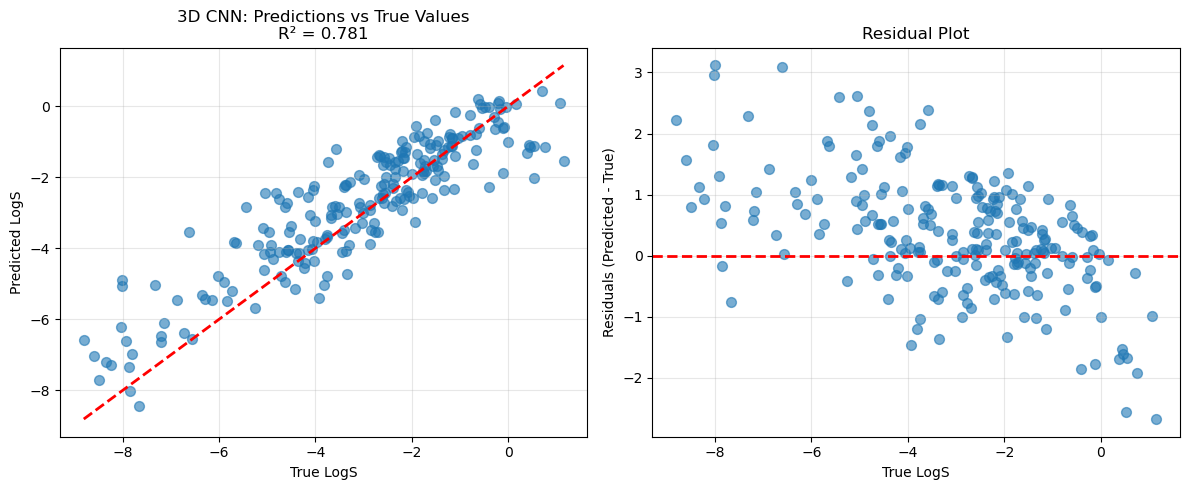

In [9]:

def evaluate_3d_model(model, test_loader):
    """Comprehensive evaluation of 3D CNN model"""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for voxel_grids, labels in test_loader:
            voxel_grids, labels = voxel_grids.to(device), labels.to(device)
            outputs = model(voxel_grids)

            all_predictions.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Calculate metrics
    mse = mean_squared_error(all_labels, all_predictions)
    mae = mean_absolute_error(all_labels, all_predictions)
    r2 = r2_score(all_labels, all_predictions)
    rmse = np.sqrt(mse)

    print("=== 3D CNN Model Evaluation ===")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")

    # Prediction quality plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(all_labels, all_predictions, alpha=0.6, s=50)
    plt.plot([min(all_labels), max(all_labels)],
             [min(all_labels), max(all_labels)], 'r--', lw=2)
    plt.xlabel('True LogS')
    plt.ylabel('Predicted LogS')
    plt.title(f'3D CNN: Predictions vs True Values\nR² = {r2:.3f}')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    residuals = np.array(all_predictions) - np.array(all_labels)
    plt.scatter(all_labels, residuals, alpha=0.6, s=50)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('True LogS')
    plt.ylabel('Residuals (Predicted - True)')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return r2, rmse, mae

# Evaluate the model
cnn_r2, cnn_rmse, cnn_mae = evaluate_3d_model(model, test_loader)


# ================================
# SECTION 8: COMPARISON WITH TRADITIONAL DESCRIPTORS
# ================================

Calculating traditional molecular descriptors...

=== Model Comparison ===
                         Model  R² Score    RMSE     MAE
0  Random Forest + Descriptors    0.8600  0.8135  0.5568
1                       3D CNN    0.7813  1.0168  0.7722


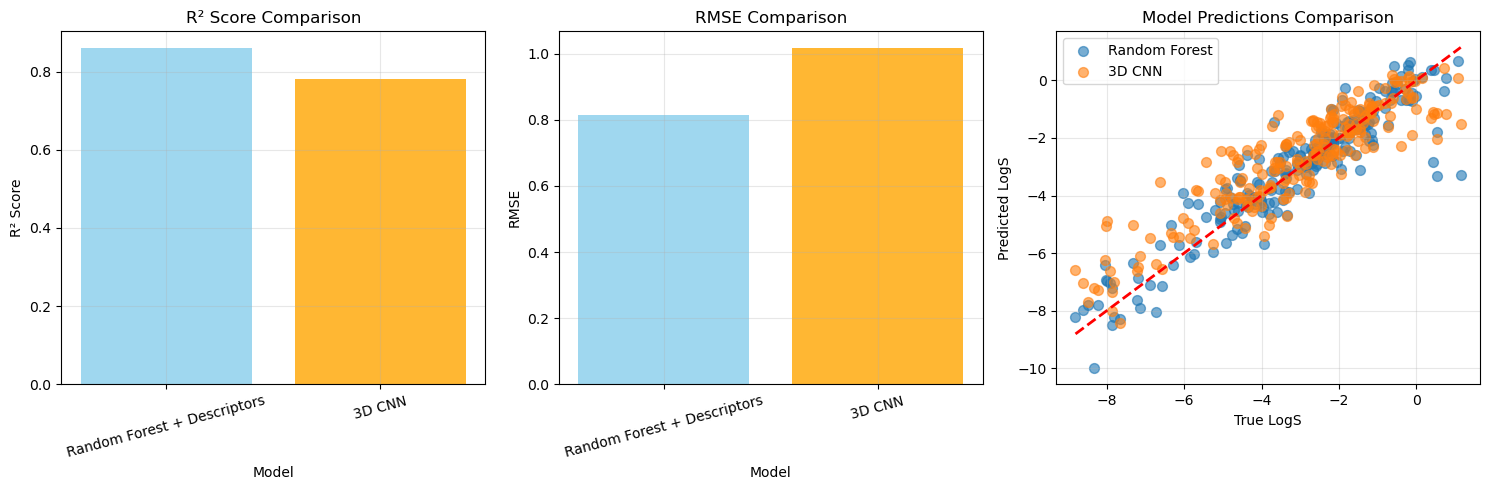

In [10]:

def calculate_molecular_descriptors(smiles_list):
    """Calculate traditional molecular descriptors"""
    descriptors = []

    # Basic descriptors available in all RDKit versions
    descriptor_functions = [
        ('MolWt', Descriptors.MolWt),
        ('LogP', Descriptors.MolLogP),
        ('NumHDonors', Descriptors.NumHDonors),
        ('NumHAcceptors', Descriptors.NumHAcceptors),
        ('TPSA', Descriptors.TPSA),
        ('NumRotatableBonds', Descriptors.NumRotatableBonds),
        ('NumAromaticRings', Descriptors.NumAromaticRings),
    ]

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            descriptors.append([0] * len(descriptor_functions))
            continue

        mol_descriptors = []
        for name, func in descriptor_functions:
            try:
                value = func(mol)
                mol_descriptors.append(value if value is not None else 0)
            except:
                mol_descriptors.append(0)

        descriptors.append(mol_descriptors)

    columns = [name for name, _ in descriptor_functions]
    return pd.DataFrame(descriptors, columns=columns)

# Calculate descriptors
print("Calculating traditional molecular descriptors...")
X_train_desc = calculate_molecular_descriptors(X_train)
X_test_desc = calculate_molecular_descriptors(X_test)

# Scale descriptors
scaler = StandardScaler()
X_train_desc_scaled = scaler.fit_transform(X_train_desc)
X_test_desc_scaled = scaler.transform(X_test_desc)

# Train Random Forest on descriptors
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_desc_scaled, y_train)

# Evaluate
rf_pred = rf_model.predict(X_test_desc_scaled)
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)

# Comparison
comparison_df = pd.DataFrame({
    'Model': ['Random Forest + Descriptors', '3D CNN'],
    'R² Score': [rf_r2, cnn_r2],
    'RMSE': [rf_rmse, cnn_rmse],
    'MAE': [rf_mae, cnn_mae]
})

print("\n=== Model Comparison ===")
print(comparison_df.round(4))

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
x = np.arange(len(comparison_df))
width = 0.35
plt.bar(x, comparison_df['R² Score'], alpha=0.8, color=['skyblue', 'orange'])
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('R² Score Comparison')
plt.xticks(x, comparison_df['Model'], rotation=15)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.bar(x, comparison_df['RMSE'], alpha=0.8, color=['skyblue', 'orange'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.xticks(x, comparison_df['Model'], rotation=15)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Side-by-side predictions plot
plt.scatter(y_test, rf_pred, alpha=0.6, label='Random Forest', s=50)
# Get 3D CNN predictions for test set
final_predictions_array = np.array(final_predictions)
plt.scatter(final_labels, final_predictions_array, alpha=0.6, label='3D CNN', s=50)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('Model Predictions Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ================================
# SECTION 9: WORKSHOP SUMMARY
# ================================

In [11]:

def result_summary():
    """Print comprehensive workshop summary"""

    print("\n📊 FINAL RESULTS SUMMARY:")
    print("-" * 40)
    print(f"3D CNN Performance:")
    print(f"  • R² Score: {cnn_r2:.4f}")
    print(f"  • RMSE: {cnn_rmse:.4f}")
    print(f"  • MAE: {cnn_mae:.4f}")

    print(f"\nTraditional ML Performance:")
    print(f"  • R² Score: {rf_r2:.4f}")
    print(f"  • RMSE: {rf_rmse:.4f}")
    print(f"  • MAE: {rf_mae:.4f}")

    print(f"\nDataset Statistics:")
    print(f"  • Total molecules: {len(df)}")
    print(f"  • Training samples: {len(train_dataset)}")
    print(f"  • Test samples: {len(test_dataset)}")
    print(f"  • LogS range: {df['LogS'].min():.2f} to {df['LogS'].max():.2f}")

# Display summary
result_summary()

# Final model save
print("\nSaving trained model...")
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': 'Molecular3DCNN',
    'performance': {
        'r2_score': cnn_r2,
        'rmse': cnn_rmse,
        'mae': cnn_mae
    },
    'training_info': {
        'grid_size': 16,
        'num_epochs': 15,
        'batch_size': batch_size
    }
}, '3d_molecular_cnn_model.pth')

print("Model saved as '3d_molecular_cnn_model.pth'")


📊 FINAL RESULTS SUMMARY:
----------------------------------------
3D CNN Performance:
  • R² Score: 0.7813
  • RMSE: 1.0168
  • MAE: 0.7722

Traditional ML Performance:
  • R² Score: 0.8600
  • RMSE: 0.8135
  • MAE: 0.5568

Dataset Statistics:
  • Total molecules: 1128
  • Training samples: 902
  • Test samples: 226
  • LogS range: -11.60 to 1.58

Saving trained model...
Model saved as '3d_molecular_cnn_model.pth'


# SUGGESTED EXERCISES:
----------------------------------------
1. Modify voxel grid resolution (8x8x8 vs 32x32x32) and compare performance
2. Implement different 3D data augmentation techniques (scaling, translation)
3. Try predicting multiple properties simultaneously (multi-task learning)
4. Experiment with different 3D CNN architectures (ResNet3D, DenseNet3D)
5. Add attention mechanisms to focus on important molecular regions
6. Implement early stopping and learning rate scheduling
7. Explore different molecular representations (distance matrices, point clouds)

# PRACTICAL TIPS:
----------------------------------------
- 3D CNNs are computationally expensive - consider GPU usage
- Voxel resolution affects both performance and computational cost
- Data augmentation is crucial for small 3D molecular datasets
- Feature visualization helps understand what the model learns
- Consider molecular size when choosing grid dimensions
----------------------------------------


## Hands-on Exercises

These are some exercises for you to implement and explore how changes in the 3D CNN pipeline affect model performance.

---

### **Exercise 1: Voxel Grid Sensitivity**

Try different combinations of grid size and voxel size. How do they affect accuracy and runtime?


## Grid size = 32 | Voxel size = 1.0 


---

### **Exercise 2: Add More Data Augmentation**

Try adding noise, shifting, or other transforms to voxel grids.



---

### **Exercise 3: Modify the CNN Architecture**

Add more Conv3D layers, change kernel sizes or pooling strategy.
